Cargo el CSV, detecto la columna de clase (y), separo X e imprimo forma y faltantes. La tabla que se ve es una vista previa de X (primeras filas y muchas columnas gen). Resultado clave: 83 muestras × 2308 genes, 0 faltantes, y la etiqueta correcta es y. Con esto queda cubierto el punto “importar y revisar huecos”.

In [47]:
import pandas as pd, numpy as np
csv_path = "A3.1_Khan.csv" 
df = pd.read_csv(csv_path)
df.columns = [c.strip() for c in df.columns]

label_col_candidates = [c for c in df.columns 
                        if df[c].nunique()<=5 and set(df[c].dropna().unique()).issubset({1,2,3,4})]
label_col = None
for cand in label_col_candidates:
    if cand.lower() in ["y","class","clase","label","etiqueta","target"]:
        label_col = cand
        break
if label_col is None:
    label_col = label_col_candidates[0]

y = df[label_col].astype(int)
X = df.drop(columns=[label_col])

print("shape:", df.shape, "| etiqueta:", label_col)
print("faltantes totales:", df.isna().sum().sum())
X.head()



shape: (83, 2309) | etiqueta: y
faltantes totales: 0


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X2299,X2300,X2301,X2302,X2303,X2304,X2305,X2306,X2307,X2308
0,0.773344,-2.438405,-0.482562,-2.721135,-1.217058,0.827809,1.342604,0.057042,0.133569,0.565427,...,-0.238511,-0.027474,-1.660205,0.588231,-0.463624,-3.952845,-5.496768,-1.414282,-0.647600,-1.763172
1,-0.078178,-2.415754,0.412772,-2.825146,-0.626236,0.054488,1.429498,-0.120249,0.456792,0.159053,...,-0.657394,-0.246284,-0.836325,-0.571284,0.034788,-2.478130,-3.661264,-1.093923,-1.209320,-0.824395
2,-0.084469,-1.649739,-0.241308,-2.875286,-0.889405,-0.027474,1.159300,0.015676,0.191942,0.496585,...,-0.696352,0.024985,-1.059872,-0.403767,-0.678653,-2.939352,-2.736450,-1.965399,-0.805868,-1.139434
3,0.965614,-2.380547,0.625297,-1.741256,-0.845366,0.949687,1.093801,0.819736,-0.284620,0.994732,...,0.259746,0.357115,-1.893128,0.255107,0.163309,-1.021929,-2.077843,-1.127629,0.331531,-2.179483
4,0.075664,-1.728785,0.852626,0.272695,-1.841370,0.327936,1.251219,0.771450,0.030917,0.278313,...,-0.200404,0.061753,-2.273998,-0.039365,0.368801,-2.566551,-1.675044,-1.082050,-0.965218,-1.836966


Ordené los genes por la magnitud de la diferencia de medias x'2 - x'4. Los primeros lugares (X187 = −3.323, X509 = −2.907, X2046 = −2.425) tienen valores negativos, lo que indica que su expresión promedio es menor en la clase 2 que en la 4 (la clase 4 es mayor por -3.32, -2.91, -2.43 unidades respectivamente, en las mismas unidades del dataset). En cambio, los genes con valores positivos (X1645 = +2.065, X1319 = +2.046, X246 = +1.838) están más altos en la clase 2 que en la 4 por esas magnitudes. Esta lista no es evidencia de significancia todavía; solo señala candidatos con efecto grande entre 2 y 4. La validación estadística se realiza en las celdas siguientes con t-tests y ajustes por pruebas múltiples.

In [36]:
mask2 = (y == 2); mask4 = (y == 4)
mean_diff_24 = (X[mask2].mean(axis=0) - X[mask4].mean(axis=0)) \
               .sort_values(key=lambda s: s.abs(), ascending=False)
top10_mean_diff = mean_diff_24.head(10).to_frame(name="mean_diff_2_minus_4")
top10_mean_diff

,mean_diff_2_minus_4
X187,-3.323151
X509,-2.906537
X2046,-2.424515
X2050,-2.401783
X129,-2.165185
X1645,2.065460
X1319,2.045941
X1955,-2.037340
X1003,-2.011337
X246,1.837830


La barra horizontal muestra, para cada gen del Top-10, la diferencia de medias x'2 - x'4. Las barras hacia la izquierda (negativas) —por ejemplo X187 (~−3.32) y X509 (~−2.91)— indican que esos genes tienen menor promedio en la clase 2 que en la 4 (la clase 4 está más alta por esa magnitud). Las barras hacia la derecha (positivas) —por ejemplo X1645 (~+2.07) y X1319 (~+2.05)— señalan genes más altos en la clase 2. La longitud de la barra refleja la magnitud del efecto y coincide con el orden de la tabla de la Celda 2; esta figura sirve para jerarquizar visualmente los candidatos, pero no implica significancia estadística por sí sola (eso se valida después con los t-tests y correcciones múltiples).

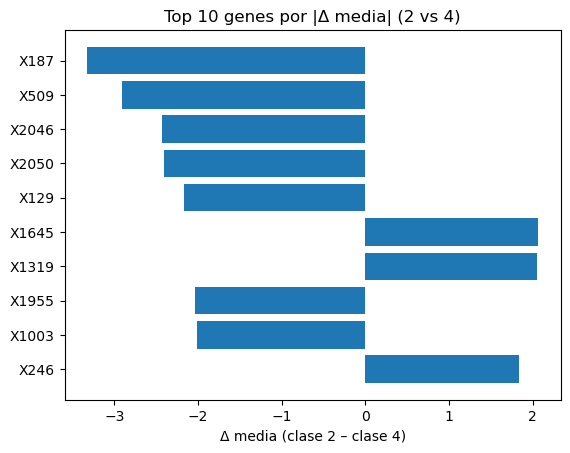

In [37]:
import matplotlib.pyplot as plt
top10_plot = top10_mean_diff.copy().reset_index().rename(columns={"index":"gene"})
plt.figure()
plt.barh(top10_plot["gene"], top10_plot["mean_diff_2_minus_4"])
plt.gca().invert_yaxis()
plt.xlabel("Δ media (clase 2 – clase 4)")
plt.title("Top 10 genes por |Δ media| (2 vs 4)")
plt.show()

Resume cuántos genes resultan significativos (α=0.05) en el t-test 2 vs 4 tras cada corrección. Con Bonferroni y Holm (ambos controlan FWER) obtienes 72 genes —son métodos estrictos, minimizan falsos positivos pero detectan menos. Con BH/FDR aparecen 296 genes —controla la proporción de falsos entre los rechazados, es más potente y por eso reporta más descubrimientos. Esto sugiere que hay evidencia amplia de diferencia entre clases 2 y 4.

In [38]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
t_stats, p_vals = [], []
cols = X.columns.tolist()
for col in cols:
    t, p = stats.ttest_ind(X.loc[mask2, col], X.loc[mask4, col],
                           equal_var=False, nan_policy='omit')
    t_stats.append(t); p_vals.append(p)

res_ttest = pd.DataFrame({"gene": cols, "t_stat": t_stats, "p_value": p_vals}) \
            .sort_values("p_value").reset_index(drop=True)

alpha = 0.05
methods = {"bonferroni":"bonferroni", "holm":"holm", "fdr_bh":"fdr_bh"}
tables = {}
for name, meth in methods.items():
    rej, p_adj, _, _ = multipletests(res_ttest["p_value"].values, alpha=alpha, method=meth)
    tmp = res_ttest.copy()
    tmp["p_adj"] = p_adj; tmp["reject"] = rej
    tables[name] = tmp

{k: int(tables[k]["reject"].sum()) for k in tables}


{'bonferroni': 72, 'holm': 72, 'fdr_bh': 296}

Se muestra una concentración de p-values cerca de 0, lo que indica que muchos genes presentan diferencias fuertes entre las clases 2 y 4. El resto de la distribución es más dispersa y casi uniforme, como se espera cuando no hay efecto. Esta forma respalda el conteo. Aun así, la decisión final sobre qué genes reportar debe basarse en los p ajustados (Bonferroni/Holm/BH) y si es posible, considerar también la magnitud del efecto (Δmedia) para priorizar hallazgos relevantes.

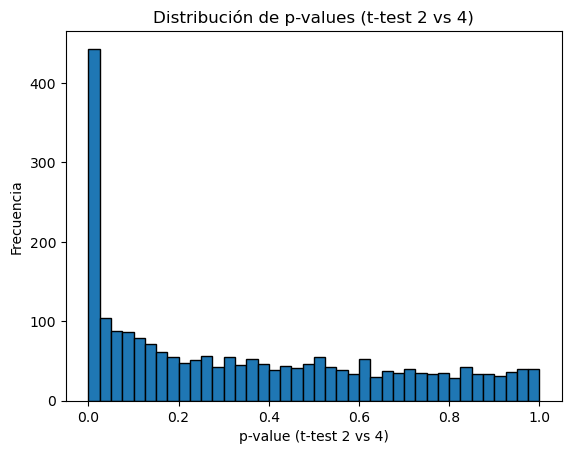

In [39]:
plt.figure()
plt.hist(res_ttest["p_value"].values, bins=40, edgecolor="black")
plt.xlabel("p-value (t-test 2 vs 4)")
plt.ylabel("Frecuencia")
plt.title("Distribución de p-values (t-test 2 vs 4)")
plt.show()


La tabla muestra los genes significativos bajo Bonferroni (FWER, α=0.05), el ajuste más estricto. Para cada gen se reporta: t_stat (magnitud del contraste), p_value (crudo), p_adj (ajustado) y reject (decisión). Los p_adj son extremadamente pequeños, por lo que todos los listados quedan con reject=True incluso con FWER. El signo de t_stat indica la dirección del efecto: valores negativos implican promedio menor en la clase 2 que en la 4 (coherente con Δmedias negativas de las celdas 2–3); en cambio, positivos (X1645 +10.83, X1940 +10.18, X1389 +9.70) indican promedio mayor en la clase 2. En resumen: estos genes son hallazgos muy robustos (superan el control FWER) y, combinando dirección (signo de t_stat) con magnitud de efecto.

In [40]:
tables["bonferroni"][tables["bonferroni"]["reject"]].head(10)

,gene,t_stat,p_value,p_adj,reject
0,X1003,-12.879590,4.998692e-17,1.153698e-13,True
1,X187,-12.229464,3.716887e-16,8.578576e-13,True
2,X2050,-10.983249,4.084836e-15,9.427801e-12,True
3,X1955,-12.579058,5.307128e-15,1.224885e-11,True
4,X1645,10.827754,8.262889e-15,1.907075e-11,True
5,X246,10.558828,1.537507e-14,3.548567e-11,True
6,X2046,-10.842463,1.769295e-14,4.083533e-11,True
7,X509,-11.334229,7.555354e-14,1.743776e-10,True
8,X1954,10.178272,9.504059e-14,2.193537e-10,True
9,X1389,9.702610,6.387904e-13,1.474328e-09,True


Aquí se aplica el ajuste Holm. los mismos genes top aparecen con reject=True y p_adj igualmente muy pequeños, por lo que pasan sin problema el umbral de α=0.05. La dirección del efecto se interpreta igual que antes: t_stat negativo (X1003 −12.88, X187 −12.23, X2050 −10.98) ⇒ promedio menor en la clase 2 que en la 4; t_stat positivo (X1645 +10.83, X1940 +10.18, X1389 +9.70) ⇒ promedio mayor en la clase 2. Dado que en tu conteo global Holm y Bonferroni dieron 72 genes significativos cada uno, esta tabla confirma que, para este conjunto, Holm no añade nuevos descubrimientos respecto a Bonferroni en el Top-10, aunque teóricamente puede producir ≥ rechazos que Bonferroni al ser menos estricto.

In [41]:
tables["holm"][tables["holm"]["reject"]].head(10)


,gene,t_stat,p_value,p_adj,reject
0,X1003,-12.879590,4.998692e-17,1.153698e-13,True
1,X187,-12.229464,3.716887e-16,8.574859e-13,True
2,X2050,-10.983249,4.084836e-15,9.419631e-12,True
3,X1955,-12.579058,5.307128e-15,1.223293e-11,True
4,X1645,10.827754,8.262889e-15,1.903770e-11,True
5,X246,10.558828,1.537507e-14,3.540879e-11,True
6,X2046,-10.842463,1.769295e-14,4.072917e-11,True
7,X509,-11.334229,7.555354e-14,1.738487e-10,True
8,X1954,10.178272,9.504059e-14,2.185934e-10,True
9,X1389,9.702610,6.387904e-13,1.468579e-09,True


Aquí aplico BH/FDR, que controla la tasa de falsos descubrimientos y suele ser más potente que los controles FWER. Los p_adj siguen siendo minúsculos, por lo que todos los genes del Top-10 quedan con reject=True. Esto es coherente con el conteo global donde FDR detectó 296 genes significativos (muchos más que Bonferroni/Holm = 72). La dirección se interpreta con t_stat: valores negativos (X1003 −12.88, X187 −12.23, X2050 −10.98) indican promedios menores en clase 2 frente a 4; positivos (X1645 +10.83, X1940 +10.18, X1389 +9.70) indican promedios mayores en clase 2. Con FDR, además de confirmar los más evidentes del Top-10, aparecen muchos más genes con evidencia suficiente.

In [42]:
tables["fdr_bh"][tables["fdr_bh"]["reject"]].head(10)


,gene,t_stat,p_value,p_adj,reject
0,X1003,-12.879590,4.998692e-17,1.153698e-13,True
1,X187,-12.229464,3.716887e-16,4.289288e-13,True
2,X2050,-10.983249,4.084836e-15,3.062213e-12,True
3,X1955,-12.579058,5.307128e-15,3.062213e-12,True
4,X1645,10.827754,8.262889e-15,3.814150e-12,True
5,X246,10.558828,1.537507e-14,5.833619e-12,True
6,X2046,-10.842463,1.769295e-14,5.833619e-12,True
7,X509,-11.334229,7.555354e-14,2.179720e-11,True
8,X1954,10.178272,9.504059e-14,2.437263e-11,True
9,X1389,9.702610,6.387904e-13,1.474328e-10,True


Evalúo, por gen, si las medias difieren entre las cuatro clases. La tabla ordena por p ascendente (o F descendente). Genes en la parte superior muestran diferencias globales claras entre clases, más allá del par 2 vs 4.

In [43]:
from scipy.stats import f_oneway
classes_sorted = sorted(y.unique())
groups = [X[y == cls] for cls in classes_sorted]

F_list, p_list = [], []
for col in X.columns:
    samples = [g[col].dropna().values for g in groups]
    F, p = f_oneway(*samples)
    F_list.append(F); p_list.append(p)

res_anova = pd.DataFrame({"gene": X.columns, "F_stat": F_list, "p_value": p_list}) \
            .sort_values("p_value").reset_index(drop=True)
res_anova.head(10)


,gene,F_stat,p_value
0,X1955,84.364086,1.459035e-24
1,X1389,83.817537,1.772751e-24
2,X1003,77.795622,1.618988e-23
3,X2050,69.230799,4.733702e-22
4,X246,68.414042,6.633722e-22
5,X742,65.572797,2.195548e-21
6,X1,59.118264,3.839240e-20
7,X2162,56.987623,1.035143e-19
8,X1954,55.419914,2.182635e-19
9,X1645,54.768403,2.988392e-19


Visualiza los 10 genes con mayor F. Sirve para comparar rápidamente qué tan fuerte es la separación multiclase de cada gen destacado. Complementa la tabla de la Celda 9.

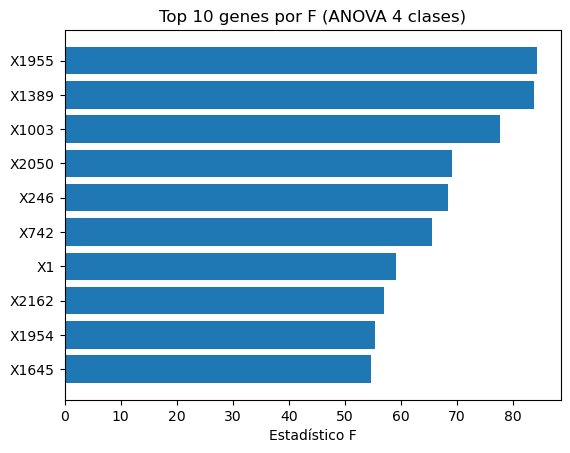

In [44]:
top10_anova = res_anova.head(10)
plt.figure()
plt.barh(top10_anova["gene"], top10_anova["F_stat"])
plt.gca().invert_yaxis()
plt.xlabel("Estadístico F")
plt.title("Top 10 genes por F (ANOVA 4 clases)")
plt.show()


Los tres muestran Accuracy = 1.0 y F1-macro = 1.0, o sea, clasificación perfecta en el conjunto de prueba con los 50 genes seleccionados. Esto suele ocurrir cuando las características elegidas separan muy bien a las clases y también puede verse favorecido porque la selección de genes se hizo con todo el dataset. Los tres modelos rinden igual; el mejor es SVM lineal por ser más simple y explicable (misma calidad con menor complejidad).

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

topN = 50
top_genes_by_anova = res_anova.head(topN)["gene"].tolist()
X_top = X[top_genes_by_anova]

X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.3, random_state=55, stratify=y
)

models = {
    "linear": SVC(kernel="linear", C=1.0, random_state=49),
    "poly3": SVC(kernel="poly", degree=3, C=1.0, gamma="scale", coef0=0.0, random_state=52),
    "rbf":   SVC(kernel="rbf", C=1.0, gamma="scale", random_state=63),
}

rows, reports, cms = [], {}, {}
for name, base in models.items():
    pipe = make_pipeline(StandardScaler(with_mean=False), base)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    rows.append({"model": name, "accuracy": acc, "f1_macro": f1m})
    reports[name] = classification_report(y_test, y_pred, output_dict=False)
    cms[name] = confusion_matrix(y_test, y_pred)
import pandas as pd
metrics_df = pd.DataFrame(rows).sort_values("f1_macro", ascending=False).reset_index(drop=True)
metrics_df

,model,accuracy,f1_macro
0,linear,1.0,1.0
1,poly3,1.0,1.0
2,rbf,1.0,1.0


La proyección PCA a 2 componentes muestra cada muestra color por su clase real. Se observan grupos bien separados en el plano (el clúster inferior derecho, el superior y el inferior izquierdo), lo que sugiere que, tras la selección de 50 genes, las clases presentan variación dominante capturada por PC1–PC2. PCA es no supervisado y solo preserva varianza global, no está optimizado para separar clases; por eso sirve como intuición (las clases parecen separables) pero no sustituye el análisis supervisado (t-tests/ANOVA) ni la evaluación de modelos (SVM).

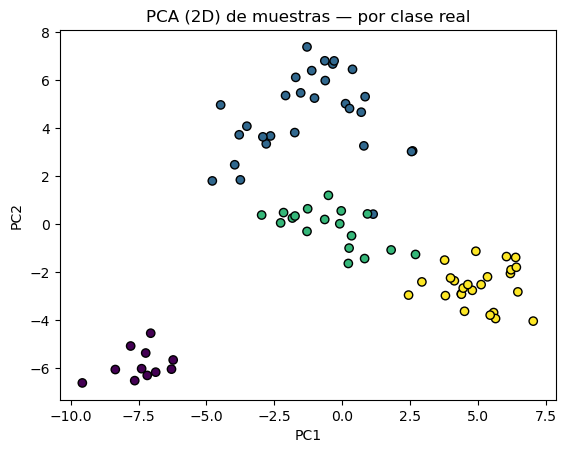

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2 = pca.fit_transform(X_top)
plt.figure()
plt.scatter(X2[:,0], X2[:,1], c=y, edgecolors="black")
plt.title("PCA (2D) de muestras — por clase real")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


Los análisis univariados muestran evidencia sólida de diferencia entre clases: el histograma de p-values se concentra cerca de 0 y, aun con controles estrictos (Bonferroni/Holm), varios genes permanecen significativos; con FDR aparecen más descubrimientos. El ANOVA confirma diferencias multiclase con F elevados en los genes top. Al usar 50 genes seleccionados, los tres SVM alcanzan desempeño perfecto en test (accuracy/F1=1.0), por lo que, por simplicidad y explicabilidad, elegiría SVM lineal. Para un estudio más riguroso, podría repetirse la selección de genes dentro de la validación (solo con train) y volver a evaluar en test para descartar cualquier sesgo por fuga de datos.